<a href="https://colab.research.google.com/github/DataMascara/food_detection/blob/master/FoodApp_ImageClassficiation_High_Accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Spring 2021 VC1A
## Supervisor: Name:  Margrethe Horlyck-Romanovsky
## Organization / Department:  Department of Health and Nutrition Sciences
## CISC 4900: Food Detection App 
## By: Lalla Sankara, Sergio Castaneda, Andrew Brennan


In [2]:
import tensorflow as tf
from tensorflow import keras


In [3]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
print(tf.__version__)

2.4.1


In [6]:
#Download data set and extract: From Tensor Flow 101 
import os
import cv2
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

In [ ]:
# Download data and extract it to folder

get_data_extract()

--2021-05-04 07:22:02--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2021-05-04 07:22:02--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz      79%[==============>     ]   3.68G  10.3MB/s    eta 94s    

In [ ]:
# Check the extracted dataset folder
!ls food-101/

In [ ]:
#showcase data set and images
import os
os.listdir('food-101/images')

['paella',
 'hummus',
 'falafel',
 'club_sandwich',
 'shrimp_and_grits',
 'carrot_cake',
 'tuna_tartare',
 'lobster_bisque',
 'spaghetti_bolognese',
 'grilled_salmon',
 'pizza',
 'croque_madame',
 'lobster_roll_sandwich',
 'samosa',
 'sushi',
 'hot_dog',
 'strawberry_shortcake',
 'bruschetta',
 'mussels',
 'ceviche',
 'panna_cotta',
 'spring_rolls',
 'macarons',
 'pulled_pork_sandwich',
 'filet_mignon',
 'deviled_eggs',
 'beef_carpaccio',
 'hot_and_sour_soup',
 'omelette',
 'prime_rib',
 'breakfast_burrito',
 'seaweed_salad',
 'poutine',
 'pork_chop',
 'pancakes',
 'lasagna',
 'frozen_yogurt',
 'grilled_cheese_sandwich',
 'beef_tartare',
 'beignets',
 'risotto',
 'ice_cream',
 'tacos',
 'huevos_rancheros',
 'pad_thai',
 'miso_soup',
 'cheese_plate',
 'pho',
 'french_toast',
 'edamame',
 'cheesecake',
 'chicken_quesadilla',
 'bibimbap',
 'oysters',
 'foie_gras',
 'steak',
 'ramen',
 'escargots',
 'creme_brulee',
 'macaroni_and_cheese',
 'fried_calamari',
 'takoyaki',
 'clam_chowder',
 '

In [ ]:
#
!head food-101/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [ ]:
#
os.listdir('food-101/meta')

['test.json',
 'test.txt',
 'labels.txt',
 'classes.txt',
 'train.txt',
 'train.json']

In [ ]:
#
!head food-101/meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


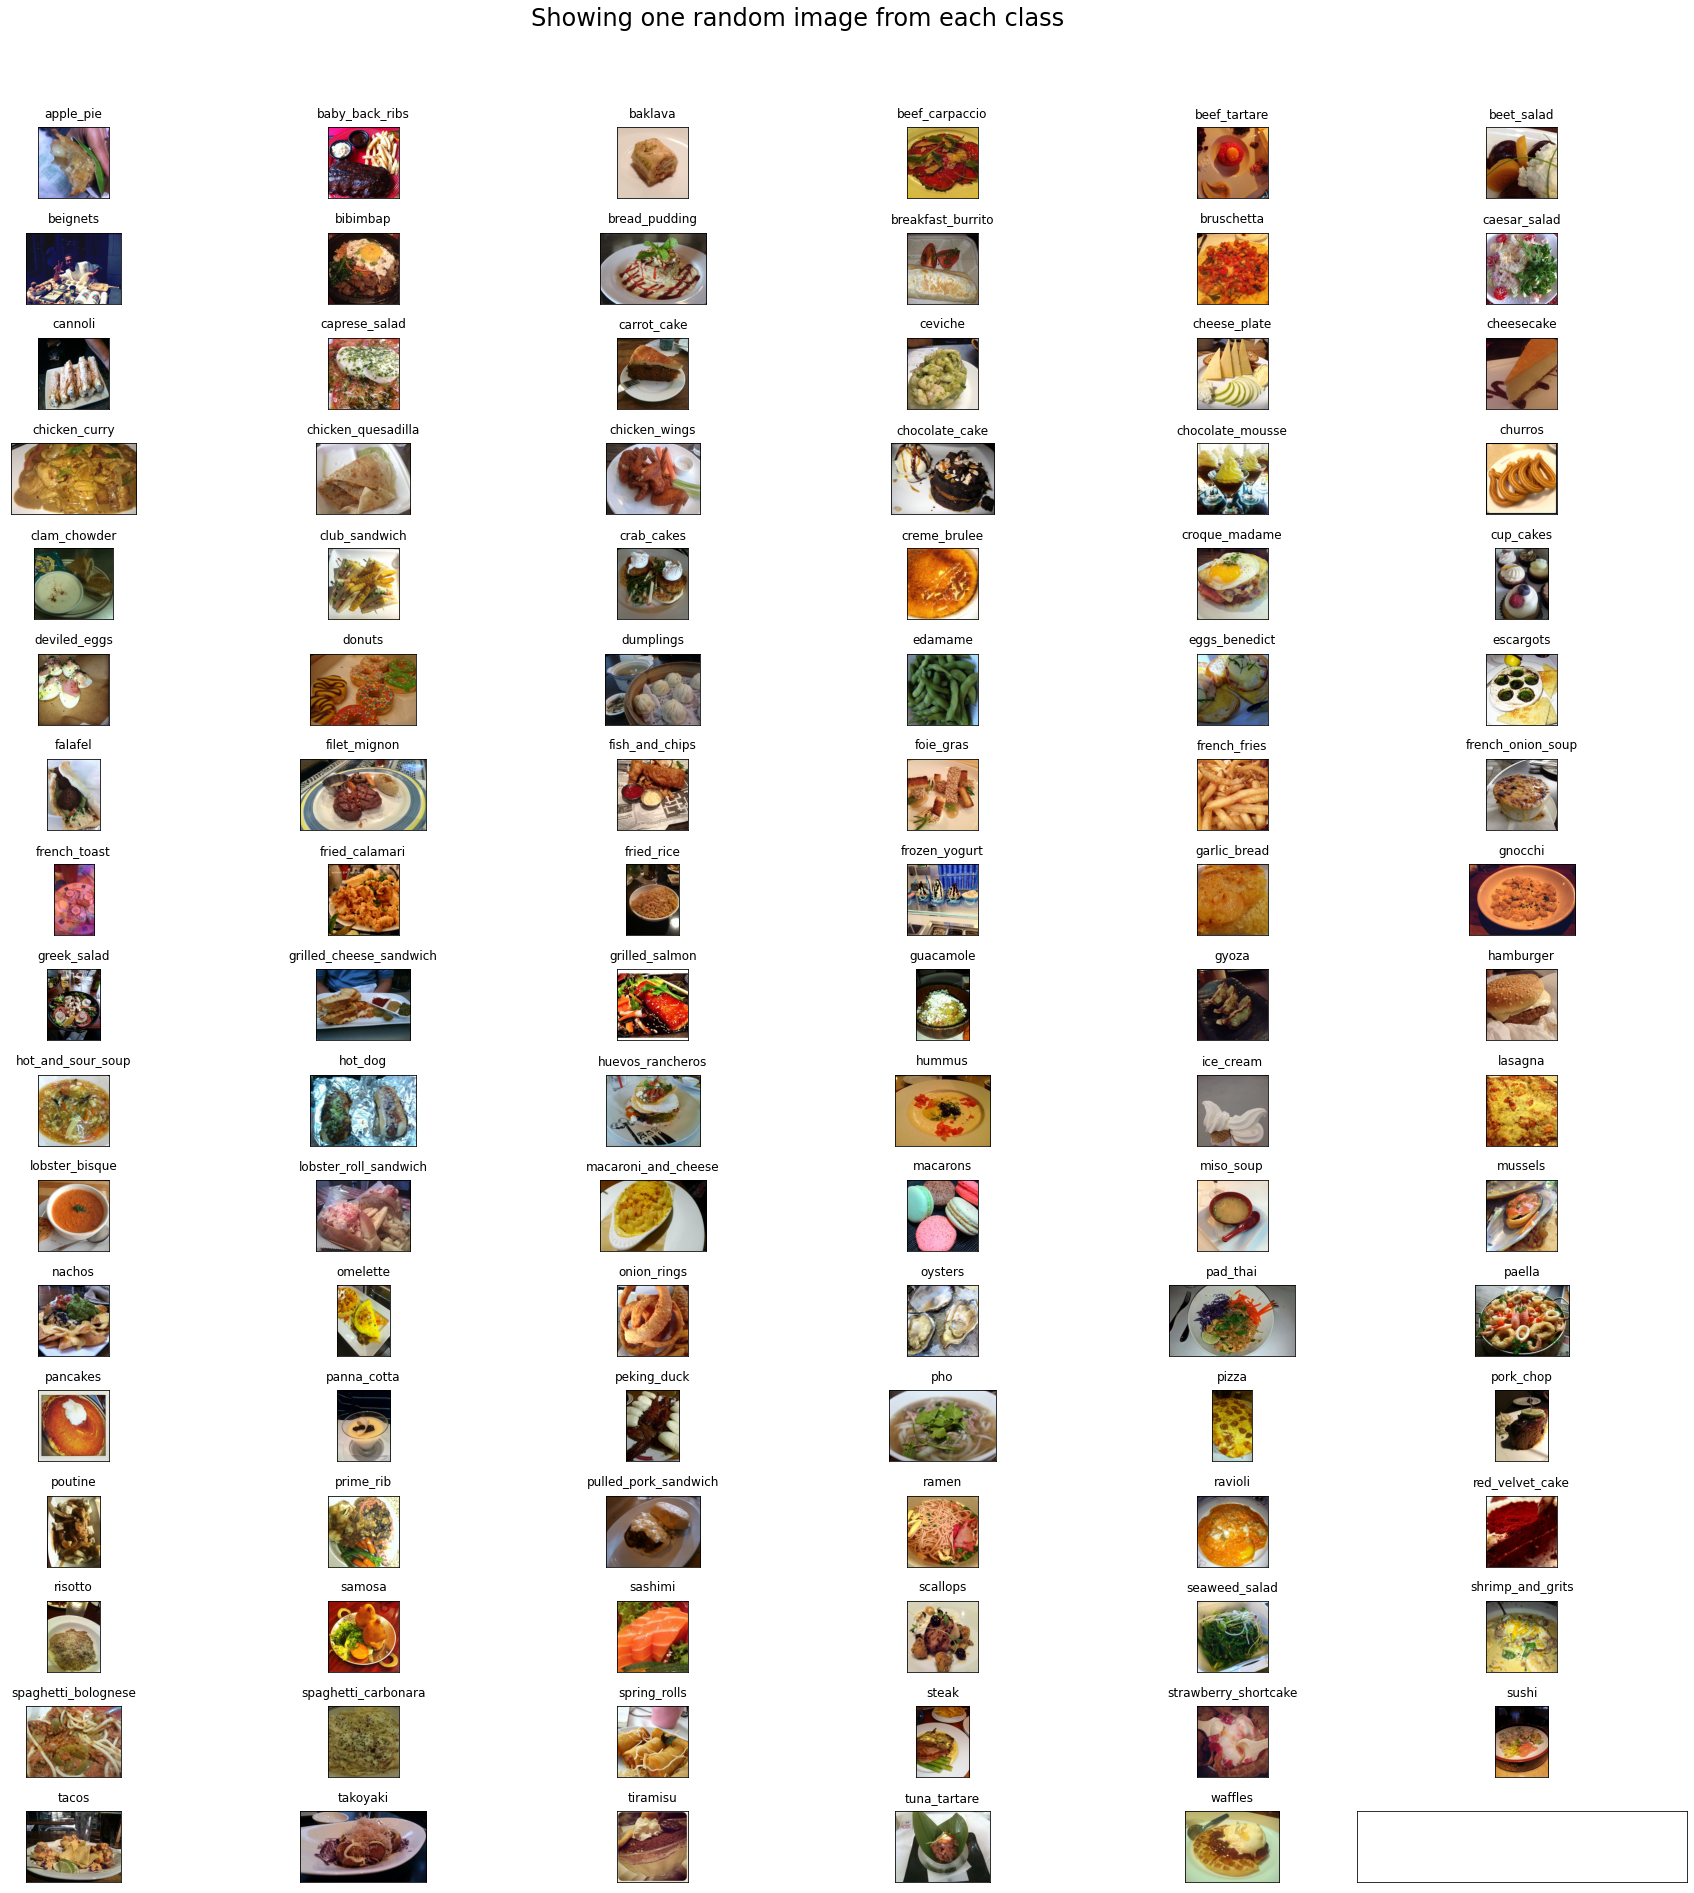

In [ ]:
## Visual Random image from each of the 101 classes
## USing 
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
import os

# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


Spliting Data by a Train and Test Sets

In [ ]:
## Split Data into train and test using train.txt and test.txt
# Helper method to split dataset into train and test folders
from shutil import copy
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [ ]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [ ]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [ ]:
# Check files in Train folder
print("Total number of samples in train folder")
!find food-101/train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [ ]:
#Check files in Test folder
print("Total number of samples in test folder")
!find food-101/test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


In [ ]:
# List of all 101 types of foods(sorted alphabetically)
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
# Helper method to create train_mini and test_mini data samples
from shutil import copytree, rmtree
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [ ]:
# Helper function to select n random food classes
import random
def pick_n_random_classes(n):
  food_list = []
  random_food_indices = random.sample(range(len(foods_sorted)),n) # We are picking n random food classes
  for i in random_food_indices:
    food_list.append(foods_sorted[i])
  food_list.sort()
  print("These are the randomly picked food classes we will be training the model on...\n", food_list)
  return food_list

In [ ]:
# picking 3 food items and generating separate data folders for the same
food_list = ['samosa','pizza','omelette']
src_train = 'food-101/train'
dest_train = 'food-101/train_mini'
src_test = 'food-101/test'
dest_test = 'food-101/test_mini'

In [ ]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into samosa
Copying images into pizza
Copying images into omelette


In [ ]:
print("Total number of samples in train folder")

!find food-101/train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
2250


In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into samosa
Copying images into pizza
Copying images into omelette


In [ ]:
print("Total number of samples in test folder")
!find food-101/test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
750


In [ ]:
# Lets try with more classes than just 3. Also, this time lets randomly pick the food classes
n = 11
food_list = pick_n_random_classes(11)

These are the randomly picked food classes we will be training the model on...
 ['bruschetta', 'caesar_salad', 'caprese_salad', 'chocolate_cake', 'falafel', 'french_toast', 'hot_and_sour_soup', 'miso_soup', 'nachos', 'pad_thai', 'steak']


In [ ]:
# Create the new data subset of n classes
print("Creating training data folder with new classes...")
dataset_mini(food_list, src_train, dest_train)


Creating training data folder with new classes...
Copying images into bruschetta
Copying images into caesar_salad
Copying images into caprese_salad
Copying images into chocolate_cake
Copying images into falafel
Copying images into french_toast
Copying images into hot_and_sour_soup
Copying images into miso_soup
Copying images into nachos
Copying images into pad_thai
Copying images into steak


In [ ]:
print("Total number of samples in train folder")
!find food-101/train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
8250


In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into bruschetta
Copying images into caesar_salad
Copying images into caprese_salad
Copying images into chocolate_cake
Copying images into falafel
Copying images into french_toast
Copying images into hot_and_sour_soup
Copying images into miso_soup
Copying images into nachos
Copying images into pad_thai
Copying images into steak


In [ ]:
print("Total number of samples in test folder")
!find food-101/test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
2750


Model Building

In [ ]:
# Pretrained Inception MOdel On subset of data with 11 food classes
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np

K.clear_session()

n_classes = n
img_width, img_height = 299, 299
train_data_dir = 'food-101/train_mini'
validation_data_dir = 'food-101/test_mini'
nb_train_samples = 8250 #75750
nb_validation_samples = 2750 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(n,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_11class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history.log')

history_11class = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=10,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_11class.hdf5')


Found 8250 images belonging to 11 classes.
Found 2750 images belonging to 11 classes.
87916544/87910968 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
296/515 [================>.............] - ETA: 56:18 - loss: 2.4643 - accuracy: 0.1743

In [ ]:
plot_accuracy(history_11class,'FOOD101-Inceptionv3')
plot_loss(history_11class,'FOOD101-Inceptionv3')

In [ ]:
# Loading the best saved model to make predictions
%%time
from tensorflow.keras.models import load_model
K.clear_session()
model_best = load_model('best_model_11class.hdf5',compile = False)

### Predicting classes for new images from internet using the best trained model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Loading the best model to make predictions
%%time
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

K.clear_session()
model_best = load_model('best_model_11class.hdf5',compile = False)

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [ ]:
# Downloading or uploading images from internet or you local computer


from google.colab import files
uploaded = files.upload()

Saving download.jpg to download.jpg


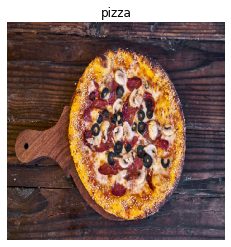

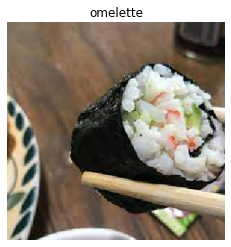

In [ ]:
# Make a list of downloaded images and test the trained model
images = []
images.append('')
images.append('')

predict_class(model_best, images, True)